In [160]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import pickle
import json
import string
import re
import warnings
from collections import defaultdict

from random import randint, shuffle
from tqdm import tqdm

import numpy as np
import nltk
import pandas as pd
from nltk import ngrams
from nltk.corpus import stopwords as st

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.models import load_model

seed = 7
np.random.seed(seed)
pd.set_option('max_colwidth', -1)

In [161]:
def plotHist(data, bins=[], x_labels=True):
    data_hist = np.random.randn(82)
    fig, ax = plt.subplots(figsize=(24,5))
    if bins: 
        counts, bins, patches = ax.hist(data, bins=bins, facecolor='yellow', edgecolor='gray')
    else:
        counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray')

    # Set the ticks to be at the edges of the bins.
    if x_labels:
        ax.set_xticks(bins)
        # Set the xaxis's tick labels to be formatted with 1 decimal place...
        ax.xaxis.set_major_formatter(FormatStrFormatter('%0.05f'))

    # Change the colors of bars at the edges...
    twentyfifth, seventyfifth = np.percentile(data_hist, [25, 75])
    for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
        if rightside < twentyfifth:
            patch.set_facecolor('green')
        elif leftside > seventyfifth:
            patch.set_facecolor('red')

    # Label the raw counts and the percentages below the x-axis...
    if x_labels:
        bin_centers = 0.5 * np.diff(bins) + bins[:-1]
        for count, x in zip(counts, bin_centers):
            # Label the raw counts
            ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -18), textcoords='offset points', va='top', ha='center')

            # Label the percentages
            percent = '%0.0f%%' % (100 * float(count) / counts.sum())
            ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -32), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.1)
    plt.show()

In [162]:
length_class_to_label = {
    0: 'full toss',
    1: 'yorker',
    2: 'full',
    3: 'good length',
    4: 'back of a length',
    5: 'short',
}

line_class_to_label = {
    0: 'wide outside off',
    1: 'outside off',
    2: 'straight',
    3: 'down leg',
    4: 'wide down leg',
}

In [204]:
def load_data(filename):
    with open(f"{filename}.json", "rb") as f:
        data = json.load(f)
    print("Loaded data!")
    return data
        
def load_pkl(filename):
    with open(f"{filename}.pkl", "rb") as f:
        d = pickle.load(f)
    return d
        
def save_data(data, filename):
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(data, f)
        
def export_to_json(data, filename):
    with open(f'{filename}.json', 'w') as json_file:
        json.dump(data, json_file)
        
i1b = lambda m : m['commentary']['innings1']['balls']
i2b = lambda m : m['commentary']['innings2']['balls']
i1o = lambda m : m['commentary']['innings1']['over_summaries']
i2o = lambda m : m['commentary']['innings2']['over_summaries']

data, players = load_data("matches_Dale Steyn2611"), load_data('player_table')

'\ni1b = lambda m : m[\'commentary\'][\'innings1\'][\'balls\']\ni2b = lambda m : m[\'commentary\'][\'innings2\'][\'balls\']\ni1o = lambda m : m[\'commentary\'][\'innings1\'][\'over_summaries\']\ni2o = lambda m : m[\'commentary\'][\'innings2\'][\'over_summaries\']\n\ndata, players = load_data("matches_Dale Steyn2611"), load_data(\'player_table\')\n'

In [166]:
lineNgrams = load_pkl("models/line_ngrams")
lengthNgrams = load_pkl("models/length_ngrams")
vocab = load_pkl("models/vocab")
lineModel = load_model("models/line__final_100N_5B_8.h5")
lengthModel = load_model("models/length__final_100N_5B_4.h5")

In [179]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemmas = []
    for w, tag in nltk.pos_tag(text):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        lemmas.append(lemmatizer.lemmatize(w, wntag) if wntag else w)
    return " ".join(lemmas)

def ngramsInText(text, ngramFeatures):
    ngramPresence = dict()
    for ngram in ngramFeatures:
        ngramSplit = ngram.split(' ')
        ngramPresence[ngram] = int(tuple(ngramSplit) in set(nltk.ngrams(text.split(' '), len(ngramSplit))))
    return pd.Series(ngramPresence).values

def classifyBall(comms):
    tokens = text_to_word_sequence(comms)
    tokens_sw = [w for w in tokens if w in vocab]
    lemmatized = lemmatize_text(tokens_sw)
    xLength = ngramsInText(lemmatized, lengthNgrams)
    xLine = ngramsInText(lemmatized, lineNgrams)
    line = lineModel.predict(np.array([xLine,]))
    length = lengthModel.predict(np.array([xLength,]))
    return (line.argmax(axis=1)[0], max(line[0])), (length.argmax(axis=1)[0],max(length[0]))

In [189]:
bowlerPattern = "(?P<bowler>[\w \-'?]+) to (?P<batsman>[\w \-']+),(?P<text_outcome>[^,]*),(?P<desc>.*)$"
for i, m in list(data.items())[301::]:
    for b in i2b(m):
        (line, line_conf), (length, length_conf) = classifyBall(b['desc'])
        desc = re.match(bowlerPattern, b['desc']).group('desc')
        tokens = text_to_word_sequence(desc)
        tokens_sw = [w for w in tokens if w in vocab]
        lemmatized = lemmatize_text(tokens_sw)
#         print(f"{desc[:75]:>75} | {lemmatized[:75]:>75} | {length_class_to_label[length]:>}, {line_class_to_label[line]:>}")
        print(f"{lemmatized[:75]:>75} | {length_class_to_label[length]:<20} {line_class_to_label[line]:<20} | {length_conf*100:>3.0f}% LENGTH, {line_conf*100:>3.0f}% LINE")
    break

deck short of length around off stump line a touch up tall down off side ri | back of a length     outside off          | 100% LENGTH,  92% LINE
                   similar length slightly outside off stump cut down point | good length          outside off          |  92% LENGTH,  98% LINE
                                                 short of length push cover | back of a length     outside off          | 100% LENGTH,  99% LINE
            beaten of a delivery up a length past outside edge big on fails | good length          outside off          |  75% LENGTH,  59% LINE
                          full in length outside off stump leave alone time | good length          outside off          |  65% LENGTH,  92% LINE
                     ah a a way down leg side poor dive full length hold on | full                 down leg             |  99% LENGTH,  89% LINE
                                             in zone outside off left alone | good length          outside off          |  27% LEN

In [60]:
comm_lengths = []
for i, m in tqdm(data.items()):
    total_length = 0
    for b in i1b(m):
        vocab_applied = classifyBall(b['desc'])
        total_length += len(vocab_applied)
    
    numBalls = len(i1b(m))
    if numBalls > 20:
        comm_lengths.append((i, 1, total_length/numBalls))
        
    total_length = 0
    for b in i2b(m):
        vocab_applied = classifyBall(b['desc'])
        total_length += len(vocab_applied)
    
    numBalls = len(i2b(m))
    if numBalls > 20:
        comm_lengths.append((i, 2, total_length/numBalls))
       

100%|██████████| 1869/1869 [00:15<00:00, 117.12it/s]


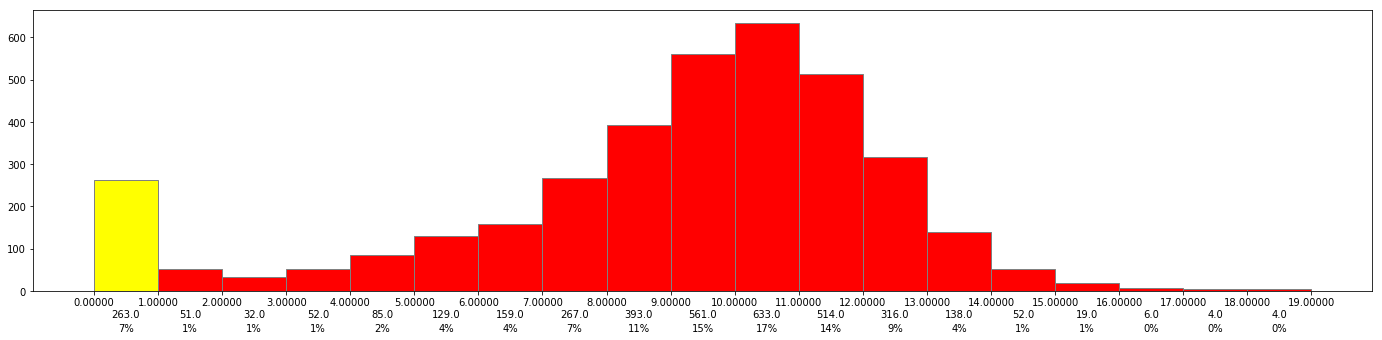

In [61]:
plotHist([x[2] for x in comm_lengths], bins = [x for x in range(20)])

In [192]:
x = dict(a=dict(b="hello"))
test = x['a']

In [193]:
test['c'] = 4

In [196]:
for i, m in data.items():
    for b in i1b(m):
        if len(b['pitch']):
            del b['pitch']['length_confidence']
            del b['pitch']['line_confidence']
            b['pitch']['length_conf'] = 100
            b['pitch']['line_conf'] = 100
            
    for b in i2b(m):
        if len(b['pitch']):
            del b['pitch']['length_confidence']
            del b['pitch']['line_confidence']
            b['pitch']['length_conf'] = 100
            b['pitch']['line_conf'] = 100

In [207]:
cl = (4,3)
x, y = cl
x

4

In [205]:
export_to_json(data, "matches_Dale Steyn2611")